<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## Get Data

In [7]:
data_origin = pd.read_csv('https://raw.githubusercontent.com/hoonzi-s/APC/main/%231%20ALK%20RVP%20CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [8]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin['RVP'] < 70) & (data_origin['T'] > 120)]
data.iloc[:, 1] += 273.15     # to Absolute
data.iloc[:, 2] += 101.325    # to Absolute
data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,RVP,T,P,F
2014-09-16,35.5,409.936039,436.615024,89.866631
2014-09-17,33.5,411.923619,439.539453,89.465610
2014-09-18,34.4,411.249435,440.881301,91.788269
2014-09-19,34.3,410.475546,437.095474,96.439654
2014-09-20,35.2,410.551238,451.085975,91.357863
...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000
2022-06-27,50.9,403.708482,486.321257,85.722808
2022-06-28,56.8,402.141628,504.938888,84.932767
2022-06-29,50.9,402.835703,480.513489,79.402347


In [9]:
A = 7.00961   # Temperature in Celsius
B = 1022.48
C = 248.145
P_ref = (335 / 101.325 + 1) * 760   # kPa to mmHg(Absolute)
conv = 760 / 101.325    # kPa to mmHg conversion factor
data['PCT'] = data.iloc[:, 1] + B * np.log10(P_ref / (data.iloc[:, 2] * conv)) / (A - np.log10(P_ref)) / (A - np.log10(data.iloc[:, 2] * conv))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RVP,T,P,F,PCT
2014-09-16,35.5,409.936039,436.615024,89.866631,409.911877
2014-09-17,33.5,411.923619,439.539453,89.465610,411.656493
2014-09-18,34.4,411.249435,440.881301,91.788269,410.871233
2014-09-19,34.3,410.475546,437.095474,96.439654,410.411384
2014-09-20,35.2,410.551238,451.085975,91.357863,409.336512
...,...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000,401.630900
2022-06-27,50.9,403.708482,486.321257,85.722808,399.710220
2022-06-28,56.8,402.141628,504.938888,84.932767,396.733150
2022-06-29,50.9,402.835703,480.513489,79.402347,399.285613


## Set 'n' and 'information'

In [10]:
n = 20
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE


# Poly T, P

## LinearRegression

In [11]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []

vars = 'Poly T, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [12]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                  'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.57086,0.569499,0.570649,0.429351,1.609208,4.809365


## Ridge

### Ridge (alpha = 0.001)

In [9]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [10]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.001,Standard,0.571535,0.566182,0.57048,0.42952,1.60955,4.811255


### Ridge (alpha = 0.01)

In [11]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [12]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.01,Standard,0.574121,0.555973,0.570224,0.429776,1.608342,4.814121


### Ridge (alpha = 0.1)

In [13]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [14]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.1,Standard,0.566946,0.56513,0.566667,0.433333,1.614386,4.853965


### Ridge (alpha = 1)

In [15]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [16]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,1,Standard,0.56954,0.546501,0.564446,0.435554,1.618298,4.878844


### Ridge (alpha = 10)

In [17]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [18]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,10,Standard,0.558166,0.559613,0.558854,0.441146,1.626457,4.941489


### Ridge (alpha = 100)

In [19]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [20]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,100,Standard,0.55479,0.54994,0.553866,0.446134,1.631515,4.997363


## Lasso

### Lasso (alpha = 0.001)

In [21]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [22]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.001,Standard,0.564926,0.565289,0.56545,0.43455,1.616664,4.867596


### Lasso (alpha = 0.01)

In [23]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [24]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.01,Standard,0.560454,0.548761,0.557965,0.442035,1.628693,4.951441


### Lasso (alpha = 0.1)

In [25]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [26]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.1,Standard,0.554888,0.548237,0.553731,0.446269,1.628525,4.998872


# Poly PCT, P

## LinearRegression

In [27]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [28]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",LinearRegression,NaN,Standard,0.570261,0.570421,0.570768,0.429232,1.608338,4.808036


## Ridge

### Ridge (alpha = 0.001)

In [29]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [30]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.001,Standard,0.569161,0.572915,0.570645,0.429355,1.608594,4.809403


### Ridge (alpha = 0.01)

In [31]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [32]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.01,Standard,0.575374,0.554046,0.570354,0.429646,1.608839,4.812665


### Ridge (alpha = 0.1)

In [33]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [34]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.1,Standard,0.567988,0.566968,0.568187,0.431813,1.612197,4.836939


### Ridge (alpha = 1)

In [35]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [36]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,1,Standard,0.564694,0.565057,0.5652,0.4348,1.616396,4.870397


### Ridge (alpha = 10)

In [37]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [38]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,10,Standard,0.562882,0.558517,0.562121,0.437879,1.621593,4.904887


### Ridge (alpha = 100)

In [39]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [40]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,100,Standard,0.56185,0.552217,0.55989,0.44011,1.623799,4.929877


## Lasso

### Lasso (alpha = 0.001)

In [41]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [42]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.869e+00, tolerance: 2.243e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.592e+00, tolerance: 2.257e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.001,Standard,0.565706,0.563371,0.565549,0.434451,1.616283,4.866495


### Lasso (alpha = 0.01)

In [43]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [44]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.01,Standard,0.559012,0.563386,0.560766,0.439234,1.623212,4.92007


### Lasso (alpha = 0.1)

In [45]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [46]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.1,Standard,0.560778,0.554319,0.559248,0.440752,1.622363,4.937067


# Poly PCT, P, F

## LinearRegression

In [47]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [48]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",LinearRegression,NaN,Standard,0.588858,0.575031,0.585836,0.414164,1.572959,4.639246


## Ridge

### Ridge (alpha = 0.001)

In [49]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [50]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.001,Standard,0.588706,0.577676,0.586234,0.413766,1.572309,4.634787


### Ridge (alpha = 0.01)

In [51]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [52]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.01,Standard,0.586266,0.580663,0.585422,0.414578,1.573177,4.643887


### Ridge (alpha = 0.1)

In [53]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [54]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.1,Standard,0.58098,0.579886,0.581451,0.418549,1.575537,4.688361


### Ridge (alpha = 1)

In [55]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [56]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,1,Standard,0.579121,0.569464,0.577295,0.422705,1.579945,4.734918


### Ridge (alpha = 10)

In [57]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [58]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,10,Standard,0.574927,0.570439,0.574076,0.425924,1.582811,4.770972


### Ridge (alpha = 100)

In [59]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [60]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,100,Standard,0.571498,0.569912,0.57158,0.42842,1.586643,4.79893


## Lasso

### Lasso (alpha = 0.001)

In [61]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [62]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e+00, tolerance: 2.283e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e+01, tolerance: 2.293e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.001,Standard,0.576653,0.579345,0.577773,0.422227,1.578285,4.729568


### Lasso (alpha = 0.01)

In [63]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [64]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.01,Standard,0.57488,0.564683,0.572807,0.427193,1.584712,4.785191


### Lasso (alpha = 0.1)

In [65]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [66]:
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.1,Standard,0.571892,0.554843,0.567271,0.432729,1.595457,4.847204


# Poly T, P, F

## LinearRegression

In [67]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [68]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",LinearRegression,NaN,Standard,0.590318,0.571648,0.586057,0.413943,1.572014,4.636773


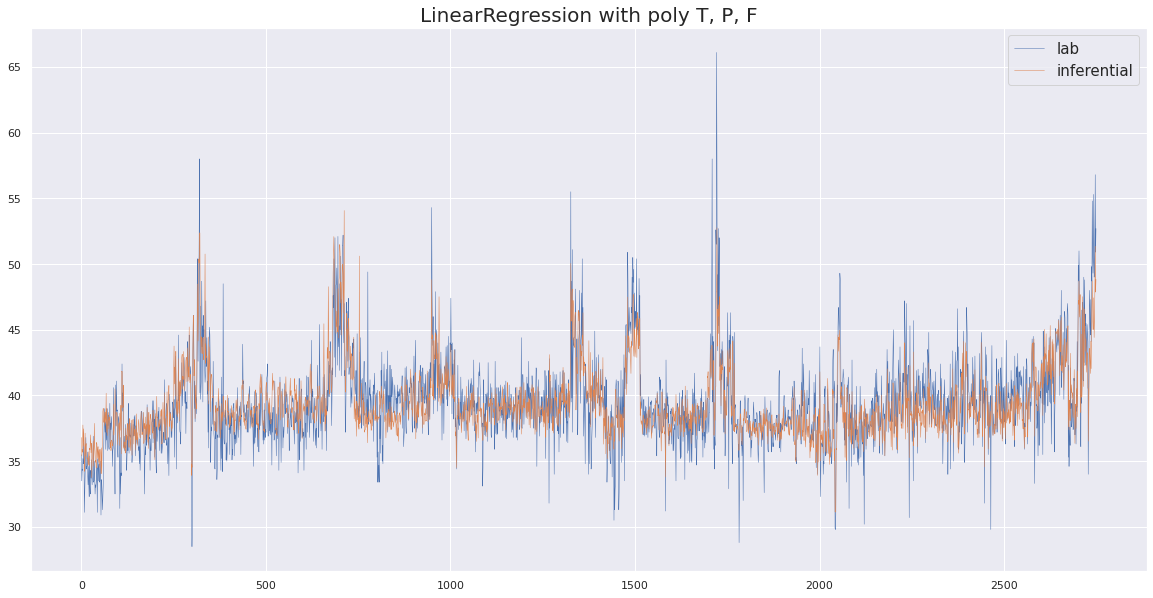

In [69]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 0.5)
plt.plot(np.arange(2750), inferential, label = 'inferential', lw = 0.5)
plt.legend(fontsize = 15)
plt.title('LinearRegression with poly T, P, F', fontsize = 20)
plt.show()

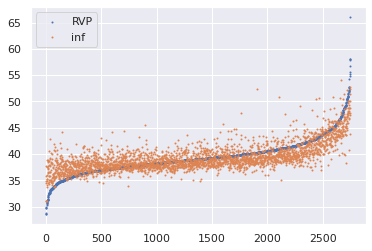

In [70]:
test = pd.DataFrame(target)
test['inf'] = inferential
test = test.sort_values(by = 'RVP')
# test = test.sort_values(by = 'inf')
test.reset_index(drop = True)
plt.scatter(np.arange(2750), test['RVP'], label = 'RVP', s = 1)
plt.scatter(np.arange(2750), test['inf'], label = 'inf', s = 1)
plt.legend()

## Ridge

### Ridge (alpha = 0.001)

In [71]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [72]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.001,Standard,0.588059,0.578106,0.586112,0.413888,1.572558,4.636151


### Ridge (alpha = 0.01)

In [73]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [74]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.01,Standard,0.590095,0.572561,0.586101,0.413899,1.57175,4.636273


### Ridge (alpha = 0.1)

In [75]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [76]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.1,Standard,0.584127,0.572594,0.581465,0.418535,1.574973,4.688213


### Ridge (alpha = 1)

In [77]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [78]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,1,Standard,0.57966,0.566935,0.576797,0.423203,1.579935,4.740492


### Ridge (alpha = 10)

In [79]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [80]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,10,Standard,0.574149,0.559071,0.570647,0.429353,1.588316,4.809381


### Ridge (alpha = 100)

In [81]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [82]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,100,Standard,0.56312,0.566339,0.564481,0.435519,1.597796,4.87845


## Lasso

### Lasso (alpha = 0.001)

In [83]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [84]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 300000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.001,Standard,0.57877,0.575294,0.578347,0.421653,1.578185,4.723139


In [85]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.44045083  8.15563371  1.1305283  -0.          0.
 -3.26150347 -6.28268281  2.20121915  0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.01)

In [86]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [87]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.01,Standard,0.56572,0.579215,0.56946,0.43054,1.590306,4.82268


In [88]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.62134318  2.75525594 -0.         -0.          0.
 -0.3714033  -0.         -0.          0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.1)

In [89]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [90]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Lasso,0.1,Standard,0.557913,0.567054,0.560676,0.439324,1.607898,4.921076


In [91]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.38335609  2.77378587 -0.         -0.          0.
 -0.19732573  0.         -0.         -0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


# Result

In [92]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,Standard,0.569938,0.570169,1.608622,4.810749,0.570525,0.429475
0,"Poly T, P",Ridge,0.001,Standard,0.571535,0.566182,1.609550,4.811255,0.570480,0.429520
0,"Poly T, P",Ridge,0.010,Standard,0.574121,0.555973,1.608342,4.814121,0.570224,0.429776
0,"Poly T, P",Ridge,0.100,Standard,0.566946,0.565130,1.614386,4.853965,0.566667,0.433333
0,"Poly T, P",Ridge,1.000,Standard,0.569540,0.546501,1.618298,4.878844,0.564446,0.435554
0,"Poly T, P",Ridge,10.000,Standard,0.558166,0.559613,1.626457,4.941489,0.558854,0.441146
0,"Poly T, P",Ridge,100.000,Standard,0.554790,0.549940,1.631515,4.997363,0.553866,0.446134
0,"Poly T, P",Lasso,0.001,Standard,0.564926,0.565289,1.616664,4.867596,0.565450,0.434550
0,"Poly T, P",Lasso,0.010,Standard,0.560454,0.548761,1.628693,4.951441,0.557965,0.442035
0,"Poly T, P",Lasso,0.100,Standard,0.554888,0.548237,1.628525,4.998872,0.553731,0.446269


In [93]:
information.drop(['train_R2', 'test_R2', 'Scaler'], axis=1)

,Variables,Solution,Alpha,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,1.608622,4.810749,0.570525,0.429475
0,"Poly T, P",Ridge,0.001,1.609550,4.811255,0.570480,0.429520
0,"Poly T, P",Ridge,0.010,1.608342,4.814121,0.570224,0.429776
0,"Poly T, P",Ridge,0.100,1.614386,4.853965,0.566667,0.433333
0,"Poly T, P",Ridge,1.000,1.618298,4.878844,0.564446,0.435554
0,"Poly T, P",Ridge,10.000,1.626457,4.941489,0.558854,0.441146
0,"Poly T, P",Ridge,100.000,1.631515,4.997363,0.553866,0.446134
0,"Poly T, P",Lasso,0.001,1.616664,4.867596,0.565450,0.434550
0,"Poly T, P",Lasso,0.010,1.628693,4.951441,0.557965,0.442035
0,"Poly T, P",Lasso,0.100,1.628525,4.998872,0.553731,0.446269


In [94]:
grouped = information['MAE'].groupby(information['Solution']).mean()

In [95]:
grouped.mean()

1.5981732422666106

In [96]:
mins = information[['MAE', 'MSE']].groupby([information['Variables'], information['Solution']]).min()
mins

MAE       MSE
Variables      Solution                            
Poly PCT, P    Lasso             1.616283  4.866495
               LinearRegression  1.608338  4.808036
               Ridge             1.608594  4.809403
Poly PCT, P, F Lasso             1.578285  4.729568
               LinearRegression  1.572959  4.639246
               Ridge             1.572309  4.634787
Poly T, P      Lasso             1.616664  4.867596
               LinearRegression  1.608622  4.810749
               Ridge             1.608342  4.811255
Poly T, P, F   Lasso             1.578185  4.723139
               LinearRegression  1.572014  4.636773
               Ridge             1.571750  4.636151

In [97]:
max = information[['train_R2', 'test_R2']].groupby([information['Variables'], information['Solution']]).max()
max

train_R2   test_R2
Variables      Solution                            
Poly PCT, P    Lasso             0.565706  0.563386
               LinearRegression  0.570261  0.570421
               Ridge             0.575374  0.572915
Poly PCT, P, F Lasso             0.576653  0.579345
               LinearRegression  0.588858  0.575031
               Ridge             0.588706  0.580663
Poly T, P      Lasso             0.564926  0.565289
               LinearRegression  0.569938  0.570169
               Ridge             0.574121  0.566182
Poly T, P, F   Lasso             0.578770  0.579215
               LinearRegression  0.590318  0.571648
               Ridge             0.590095  0.578106

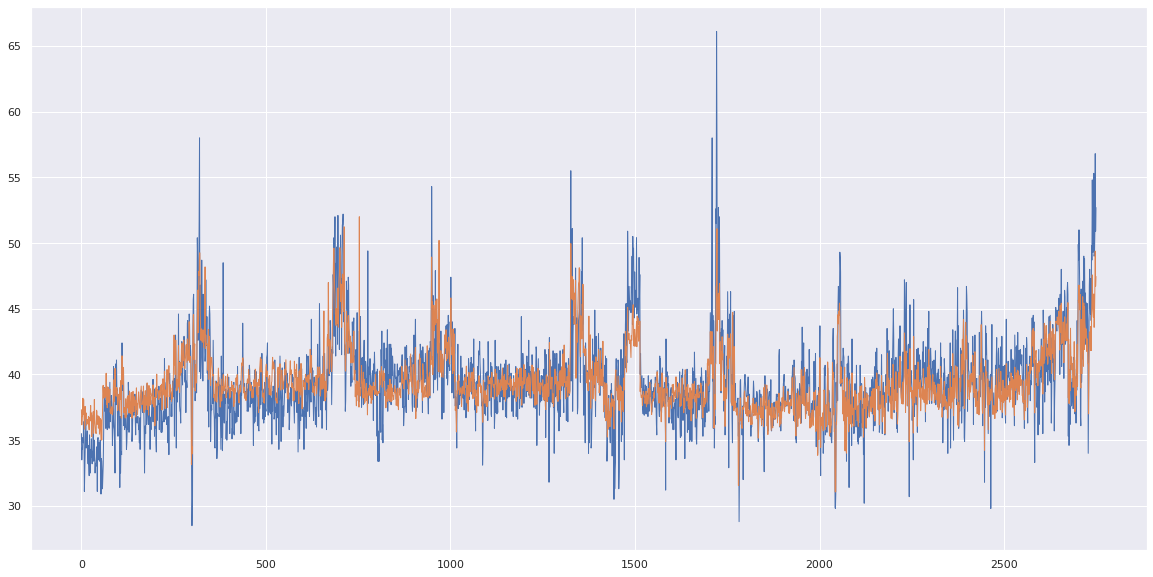

In [98]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')

# XGBoost

In [17]:
xgb = XGBRegressor()
xgb.fit(train_input, train_target)
print(f'train_R2: {xgb.score(train_input, train_target)}')
print(f'test_R2: {xgb.score(test_input, test_target)}')
print(f'R2: {r2_score(target, xgb.predict(input_poly))}')
inferential = xgb.predict(input_poly)
print(f'MAE: {MAE(target, inferential)}')
print(f'MSE: {MSE(target, inferential)}')

[04:46:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_R2: 0.6880260864404327
test_R2: 0.5200215999991095
R2: 0.6316908856512646
MAE: 1.5038132766723633
MSE: 4.12560431159349


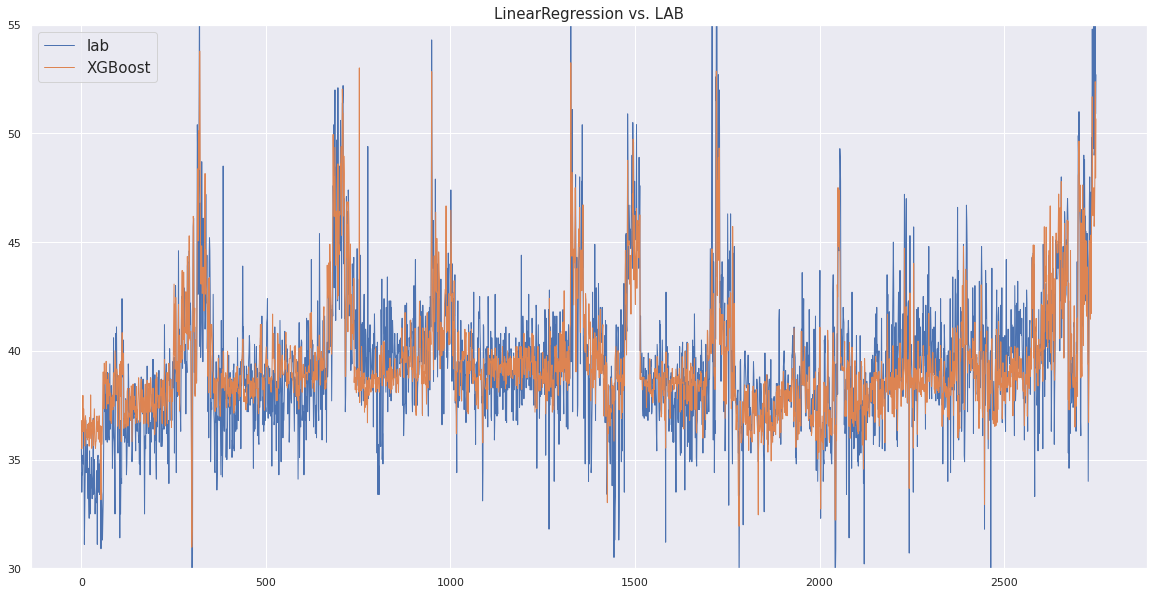

In [18]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'XGBoost', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('LinearRegression vs. LAB', fontsize = 15)
plt.savefig('inf_.xgbregressor.png', dpi = 300, bbox_inches = 'tight')
plt.show()